# BERT for Spooky Author Identification

### **References:**
- Source for `bert_encode` function: https://www.kaggle.com/user123454321/bert-starter-inference
- All pre-trained BERT models from Tensorflow Hub: https://tfhub.dev/s?q=bert
- TF Hub Documentation for Bert Model: https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1

In [1]:
# We will use the official tokenization script created by the Google team
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from tensorflow.keras import callbacks
from keras.utils import to_categorical

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import word_tokenize
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, log_loss
import pprint

import tokenization

import re
import gc
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
notebookstart = time.time()
pd.options.display.max_colwidth = 500

print("Tensorflow Version: ", tf.__version__)
print("TF-Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.test.is_gpu_available())

Tensorflow Version:  2.3.1
TF-Hub version:  0.10.0
Eager mode enabled:  True
GPU available:  True


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
MAX_LEN = 64
BATCH_SIZE = 16
EPOCHS = 10
SEED = 42
NROWS = None
TEXTCOL = "text"
TARGETCOL = "author"
NCLASS = 3

# Helper Functions

In [4]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

def text_processing(df, TEXTCOL, sentiment=False):
    df[TEXTCOL + '_num_words'] = df[TEXTCOL].apply(lambda comment: len(comment.split())) # Count number of Words
    df[TEXTCOL + '_num_unique_words'] = df[TEXTCOL].apply(lambda comment: len(set(w for w in comment.split())))
    df[TEXTCOL + '_words_vs_unique'] = df[TEXTCOL+'_num_unique_words'] / df[TEXTCOL+'_num_words'] * 100 # Count Unique Words
    
    col_names = [TEXTCOL + '_num_words', TEXTCOL + '_num_unique_words', TEXTCOL + '_words_vs_unique']
    if sentiment:
        df[TEXTCOL+"_vader_Compound"]= df[TEXTCOL].apply(lambda x:SIA.polarity_scores(x)['compound'])
        col_names.append(TEXTCOL+"_vader_Compound")

    return df, col_names

def build_model(bert_layer, max_len=512, dropout=.2):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    numeric_inputs = Input(shape=(len(num_cols),), dtype=tf.float32, name="numeric_inputs")
    
    # Bert Layer
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    
    # Sequence Output
    sequence_output = SpatialDropout1D(dropout)(sequence_output)
    sequence_output = Bidirectional(LSTM(128, return_sequences=True))(sequence_output)
    sequence_output = GlobalAveragePooling1D()(sequence_output)
    
    # Pooled Output
    pooled_output = Dense(36, activation='relu')(pooled_output)
    
    # Dense Inputs
    numeric_x = Dense(512, activation='relu')(numeric_inputs)
    numeric_x = Dropout(dropout)(numeric_x)
    numeric_x = Dense(64, activation='relu')(numeric_x)
    
    # Concatenate
    cat = concatenate([
        pooled_output,
        sequence_output,
        numeric_x
    ])
    cat = Dropout(dropout)(cat)
    
    # Output Layer
    out = Dense(3, activation='softmax')(cat)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids, numeric_inputs], outputs=out)
    model.compile(Adam(lr=1e-6), loss='categorical_crossentropy', metrics=['acc'])
    
    return model

In [5]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 27.3 s, sys: 6.34 s, total: 33.6 s
Wall time: 36.2 s


In [6]:
train = pd.read_csv("../input/spooky-author-identification/train.zip", nrows=NROWS)
test = pd.read_csv("../input/spooky-author-identification/test.zip")
testdex = test.id
submission = pd.read_csv("../input/spooky-author-identification/sample_submission.zip")
sub_cols = submission.columns

print("Train Shape: {} Rows, {} Columns".format(*train.shape))
print("Test Shape: {} Rows, {} Columns".format(*test.shape))

length_info = [len(x) for x in np.concatenate([train[TEXTCOL].values, test[TEXTCOL].values])]
print("Train Sequence Length - Mean {:.1f} +/- {:.1f}, Max {:.1f}, Min {:.1f}".format(
    np.mean(length_info), np.std(length_info), np.max(length_info), np.min(length_info)))

Train Shape: 19579 Rows, 3 Columns
Test Shape: 8392 Rows, 2 Columns
Train Sequence Length - Mean 148.7 +/- 107.7, Max 4663.0, Min 21.0


In [7]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.",EAP
1,id17569,It never once occurred to me that the fumbling might be a mere mistake.,HPL
2,id11008,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.",EAP
3,id27763,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.",MWS
4,id12958,"Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.",HPL


In [8]:
# Text Processing
SIA = SentimentIntensityAnalyzer()
train_df, dense_vars = text_processing(train.copy(), TEXTCOL, sentiment=True)
test_df, _ = text_processing(test.copy(), TEXTCOL, sentiment=True)

In [9]:
# TF-IDF
count_vectorizer = TfidfVectorizer(
    analyzer="word",
    tokenizer=word_tokenize,
    preprocessor=None,
    stop_words='english',
    sublinear_tf=True,
    ngram_range=(1, 1),
    max_features=500)    

hash_loc_tfidf = count_vectorizer.fit(train_df[TEXTCOL])
tfvocab = hash_loc_tfidf.get_feature_names()
print("Number of TF-IDF Features: {}".format(len(tfvocab)))

train_tfidf = count_vectorizer.transform(train_df[TEXTCOL])
test_tfidf = count_vectorizer.transform(test_df[TEXTCOL])

# Normalisation - Standard Scaler
for d_i in dense_vars:
    scaler = StandardScaler()
    scaler.fit(train_df.loc[:,d_i].values.reshape(-1, 1))
    train_df.loc[:,d_i] = scaler.transform(train_df.loc[:,d_i].values.reshape(-1, 1))
    test_df.loc[:,d_i] = scaler.transform(test_df.loc[:,d_i].values.reshape(-1, 1))
    
# Sparse Stack
train_num = hstack([csr_matrix(train_df.loc[:,dense_vars].values),train_tfidf]).toarray()
test_num = hstack([csr_matrix(test_df.loc[:,dense_vars].values),test_tfidf]).toarray()
num_cols = train_df[dense_vars].columns.tolist() + tfvocab

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Number of TF-IDF Features: 500


In [10]:
# Bert Pre-Processing
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

train_input_word_ids, train_input_mask, train_segment_ids, train_numeric_inputs = *bert_encode(train[TEXTCOL].values, tokenizer, max_len=MAX_LEN), train_num
test_input = (*bert_encode(test[TEXTCOL].values, tokenizer, max_len=MAX_LEN), test_num)

label_mapper = {name: i for i,name in enumerate(set(train[TARGETCOL].values))}
num_label = np.vectorize(label_mapper.get)(train[TARGETCOL].values)
train_labels = to_categorical(num_label)

del test, train_num, test_num, train_df, test_df
_ = gc.collect()

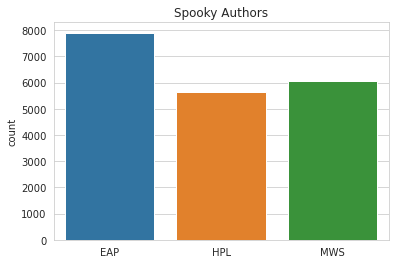

In [11]:
sns.countplot(train[TARGETCOL].values)
plt.title("Spooky Authors")
plt.show()

# Model: Build, Train, Predict, Submit

In [12]:
model = build_model(bert_layer, max_len=MAX_LEN)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 64)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 64)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

Epoch 1/10
726/726 [==============================] - 386s 531ms/step - loss: 0.9395 - acc: 0.5427 - val_loss: 0.7002 - val_acc: 0.7164
Epoch 2/10
726/726 [==============================] - 381s 525ms/step - loss: 0.5949 - acc: 0.7608 - val_loss: 0.5326 - val_acc: 0.7838
Epoch 3/10
726/726 [==============================] - 381s 524ms/step - loss: 0.4435 - acc: 0.8267 - val_loss: 0.4746 - val_acc: 0.8083
Epoch 4/10
726/726 [==============================] - 381s 524ms/step - loss: 0.3444 - acc: 0.8721 - val_loss: 0.4671 - val_acc: 0.8223
Epoch 5/10
726/726 [==============================] - 380s 524ms/step - loss: 0.2634 - acc: 0.9068 - val_loss: 0.4534 - val_acc: 0.8299
Epoch 6/10
726/726 [==============================] - 381s 524ms/step - loss: 0.1876 - acc: 0.9377 - val_loss: 0.4784 - val_acc: 0.8365
Epoch 7/10
726/726 [==============================] - 380s 524ms/step - loss: 0.1248 - acc: 0.9650 - val_loss: 0.5127 - val_acc: 0.8365
Epoch 00007: early stopping
{'acc': 0.9068341851

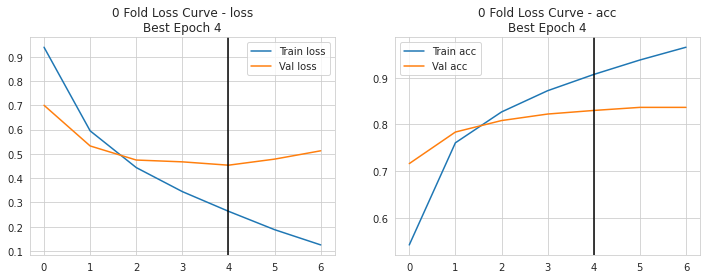

Epoch 1/10
726/726 [==============================] - 383s 528ms/step - loss: 0.4466 - acc: 0.8414 - val_loss: 0.2287 - val_acc: 0.9278
Epoch 2/10
726/726 [==============================] - 380s 524ms/step - loss: 0.2682 - acc: 0.9085 - val_loss: 0.2225 - val_acc: 0.9225
Epoch 3/10
726/726 [==============================] - 380s 524ms/step - loss: 0.1845 - acc: 0.9411 - val_loss: 0.2019 - val_acc: 0.9335
Epoch 4/10
726/726 [==============================] - 380s 523ms/step - loss: 0.1288 - acc: 0.9633 - val_loss: 0.2057 - val_acc: 0.9332
Epoch 5/10
726/726 [==============================] - 380s 524ms/step - loss: 0.0803 - acc: 0.9802 - val_loss: 0.2149 - val_acc: 0.9332
Epoch 00005: early stopping
{'acc': 0.9410863518714905,
 'loss': 0.18450763821601868,
 'val_acc': 0.9334967732429504,
 'val_loss': 0.2019120454788208}


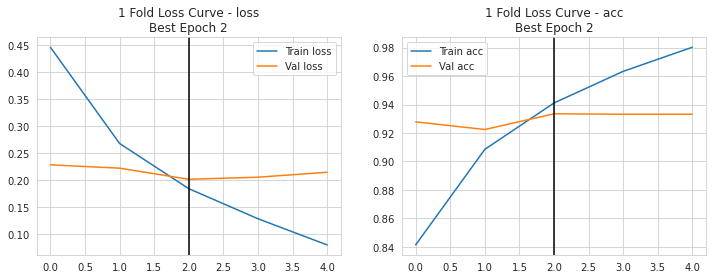

Epoch 1/10
726/726 [==============================] - 384s 528ms/step - loss: 0.3078 - acc: 0.9006 - val_loss: 0.1035 - val_acc: 0.9703
Epoch 2/10
726/726 [==============================] - 381s 525ms/step - loss: 0.1562 - acc: 0.9540 - val_loss: 0.0787 - val_acc: 0.9778
Epoch 3/10
726/726 [==============================] - 379s 522ms/step - loss: 0.0916 - acc: 0.9770 - val_loss: 0.0806 - val_acc: 0.9749
Epoch 4/10
726/726 [==============================] - 380s 523ms/step - loss: 0.0533 - acc: 0.9890 - val_loss: 0.0816 - val_acc: 0.9753
Epoch 00004: early stopping
{'acc': 0.9539569616317749,
 'loss': 0.15615476667881012,
 'val_acc': 0.9777811765670776,
 'val_loss': 0.07867418229579926}


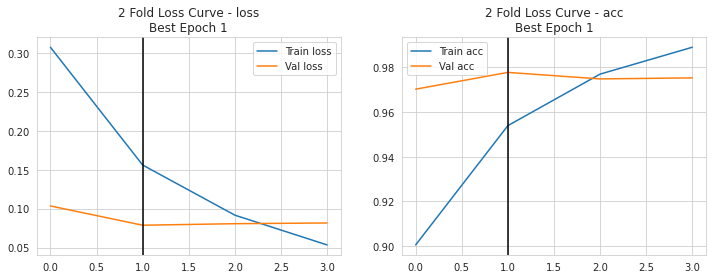

In [13]:
oof_preds = np.zeros((train_input_word_ids.shape[0], NCLASS))
test_preds = np.zeros((testdex.shape[0], NCLASS))

n_splits = 3
folds = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
plot_metrics = ['loss','acc']

fold_hist = {}
for i, (trn_idx, val_idx) in enumerate(folds.split(train_input_word_ids)):
    modelstart = time.time()
    model = build_model(bert_layer, max_len=MAX_LEN)
    
    es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose=1,
                                 mode='min', baseline=None, restore_best_weights=True)
    
    
    history = model.fit(
        x=[train_input_word_ids[trn_idx],
            train_input_mask[trn_idx],
            train_segment_ids[trn_idx],
            train_numeric_inputs[trn_idx]],
        y=train_labels[trn_idx],
        validation_data=(
            [train_input_word_ids[val_idx],
            train_input_mask[val_idx],
            train_segment_ids[val_idx],
            train_numeric_inputs[val_idx]],
            train_labels[val_idx]),
        epochs=EPOCHS,
        batch_size=18,
        callbacks=[es]
    )

    best_index = np.argmin(history.history['val_loss'])
    fold_hist[i] = history
    
    oof_preds[val_idx] = model.predict(
        [train_input_word_ids[val_idx],
        train_input_mask[val_idx],
        train_segment_ids[val_idx],
        train_numeric_inputs[val_idx]])
    test_preds += model.predict(test_input)
    best_metrics = {metric: scores[best_index] for metric, scores in history.history.items()}
    pprint.pprint(best_metrics)
    
    f, ax = plt.subplots(1,len(plot_metrics),figsize = [12,4])
    for p_i,metric in enumerate(plot_metrics):
        ax[p_i].plot(history.history[metric], label='Train ' + metric)
        ax[p_i].plot(history.history['val_' + metric], label='Val ' + metric)
        ax[p_i].set_title("{} Fold Loss Curve - {}\nBest Epoch {}".format(i, metric, best_index))
        ax[p_i].legend()
        ax[p_i].axvline(x=best_index, c='black')
    plt.show()

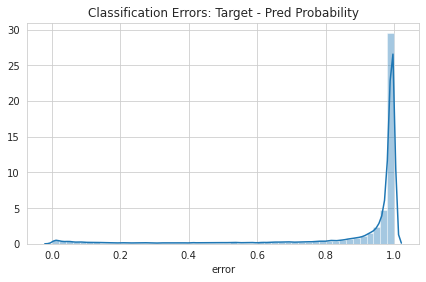

In [14]:
train['error'] = 1 - np.max(((train_labels) - oof_preds), axis = 1)
train = pd.concat([train, pd.DataFrame(oof_preds, columns=label_mapper.keys())], axis=1)


f,ax = plt.subplots(1,1,figsize = [6,4])
sns.distplot(train['error'], ax = ax)
ax.set_title("Classification Errors: Target - Pred Probability")
plt.tight_layout(pad=1)
plt.show()

In [15]:
cnf_matrix = confusion_matrix(num_label, np.argmax(oof_preds,axis=1))
print("Logloss: {:.2f}".format(log_loss(train_labels, oof_preds)))

print("\nConfusion Matrix:")
print(cnf_matrix)

Logloss: 0.24

Confusion Matrix:
[[5505  150  389]
 [ 116 5251  268]
 [ 419  347 7134]]


In [16]:
show_cols = [
    'id',
    TEXTCOL,
    TARGETCOL,
    'error'] + list(label_mapper.keys())

display(train[show_cols].sort_values(by = 'error', ascending=True).iloc[:20])

,id,text,author,error,MWS,HPL,EAP
6633,id07450,"As the minuteness of the parts formed a great hindrance to my speed, I resolved, contrary to my first intention, to make the being of a gigantic stature, that is to say, about eight feet in height, and proportionably large.",MWS,0.000870,0.000870,0.001039,0.998091
4097,id12495,"Besides, though the violence of her anguish made life hateful, it had not yet produced that monotonous, lethargic sense of changeless misery which for the most part produces suicide.",MWS,0.000877,0.000877,0.996732,0.002391
13228,id11010,"I remembered, too, strange stories told about these Ragged Hills, and of the uncouth and fierce races of men who tenanted their groves and caverns.",EAP,0.001066,0.003481,0.995453,0.001066
6645,id04525,"We had previously opened the doors of all the other rooms on that hall, and flung all the windows to the very top.",HPL,0.001187,0.001124,0.001187,0.997689
1941,id13985,"All of these, however, bore out the notes in full.",HPL,0.001245,0.000584,0.001245,0.998170
4045,id27048,"I remembered also the nervous fever with which I had been seized just at the time that I dated my creation, and which would give an air of delirium to a tale otherwise so utterly improbable.",MWS,0.001268,0.001268,0.983232,0.015500
13587,id17144,Nature is full of such illusions to impress the imaginative.,HPL,0.001539,0.003015,0.001539,0.995445
1780,id18191,"In the midst of these reflections, as if dramatically arranged to intensify them, there fell near by a terrific bolt of lightning followed by the sound of sliding earth.",HPL,0.001639,0.001440,0.001639,0.996921
12536,id15330,"Through this crevice a small room was visible, whitewashed and clean but very bare of furniture.",MWS,0.001683,0.001683,0.996237,0.002080
3050,id27194,"Gradually the object of fear sank beneath the horizon, and to the last shot up shadowy beams into the otherwise radiant air.",MWS,0.001760,0.001760,0.986320,0.011920


In [17]:
final_pred = test_preds/n_splits
pd.DataFrame(final_pred).describe()

,0,1,2
count,8392.000000,8392.000000,8392.000000
mean,0.303894,0.293733,0.402372
std,0.410872,0.412016,0.429881
min,0.000513,0.000596,0.000902
25%,0.002873,0.003154,0.007501
50%,0.020259,0.017497,0.129446
75%,0.807636,0.756849,0.937051
max,0.997492,0.998052,0.998444


In [18]:
submission = pd.DataFrame(final_pred, columns=label_mapper.keys())
submission['id'] = testdex

submission = submission[sub_cols]
submission.to_csv('submission_bert.csv', index=False)
print(submission.shape)

(8392, 4)


In [19]:
!head submission_bert.csv

id,EAP,HPL,MWS
id02310,0.007038029143586755,0.008498638635501266,0.9844633539517721
id24541,0.9275180498758951,0.06374192206809919,0.008740035351365805
id00134,0.0013636491106202204,0.9979280829429626,0.0007082544713436315
id27757,0.7238655289014181,0.272758886218071,0.003375632300352057
id04081,0.9559254248936971,0.04031749566396078,0.0037570808393259845
id27337,0.9965609709421793,0.001430683924506108,0.002008377651994427
id24265,0.9747701088587443,0.0031217477517202497,0.022108170048644144
id25917,0.003923775861039758,0.01721559775372346,0.9788606365521749
id04951,0.9969030022621155,0.0016996708776180942,0.0013973346600929897


In [20]:
oof_pd = pd.DataFrame(oof_preds/n_splits, columns = label_mapper.keys())
oof_pd.to_csv("oof_dense_bert.csv")
print(oof_pd.shape)

(19579, 3)


In [21]:
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))

Notebook Runtime: 112.70 Minutes
